# Predicting molecular properties with machine learning

### Dataset

Dataset - Quantum chemistry structures and properties of 134 kilo molecules (https://www.nature.com/articles/sdata201422).

It contains geometric, energetic, electronic, and thermodynamic properties for 134k stable small organic molecules.

The molecules are composed of carbon (C), hydrogen (H), oxygen (O), nitrogen (N), and fluorine (F).

### Objective

The objective of the project is to predict the molecular properties of these small organic molecules using the Coulomb matrix representation.

We will use the eigenvalues of the Coulomb matrix, which serve as a crucial descriptor for capturing the electronic structure of molecules for predicting molecular properties.

### Properties

| No. | Property | Unit         | Description                            |
|-----|----------|--------------|----------------------------------------|
| 1   | tag      | —            | ‘gdb9’ string to facilitate extraction|
| 2   | i        | —            | Consecutive, 1-based integer identifier|
| 3   | A        | GHz          | Rotational constant                   |
| 4   | B        | GHz          | Rotational constant                   |
| 5   | C        | GHz          | Rotational constant                   |
| 6   | μ        | D            | Dipole moment                         |
| 7   | α        | a³           | Isotropic polarizability              |
| 8   | εHOMO    | Ha           | Energy of HOMO                        |
| 9   | εLUMO    | Ha           | Energy of LUMO                        |
| 10  | εgap     | Ha           | Gap (εLUMO − εHOMO)                   |
| 11  | /R2S     | a²           | Electronic spatial extent             |
| 12  | zpve     | Ha           | Zero point vibrational energy         |
| 13  | U0       | Ha           | Internal energy at 0 K                |
| 14  | U        | Ha           | Internal energy at 298.15 K           |
| 15  | H        | Ha           | Enthalpy at 298.15 K                  |
| 16  | G        | Ha           | Free energy at 298.15 K               |
| 17  | C v      | cal/mol·K    | Heat capacity at 298.15 K             |


In [1]:
import pandas as pd
import os
import opendatasets as od
from tqdm import tqdm
from pathlib import Path
import shutil
import random
from coulumb_utils.xyz import read_xyz, create_dataframe_from_xyz
from coulumb_utils.calculate_coulumb_matrix import calculate_coulomb_matrix
from coulumb_utils.sort_molecules import sort_by_row_norm
from coulumb_utils.normalize import normalize_min_max
from coulumb_utils.eigen_padd import compute_eigenvalues, padd_eig, padd_matrix
from coulumb_utils.standardize import standardize_matrix
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator,ScalarFormatter
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.linear_model import Ridge
from xgboost import plot_importance

# Download dataset

The dataset is on Kaggle - https://www.kaggle.com/datasets/mariovozza5/qm9-molecules

In [2]:

dataset = "https://www.kaggle.com/datasets/mariovozza5/qm9-molecules"

if not os.path.exists("qm9-molecules"): od.download(dataset)

# Load xyz files

The dataset contains XYZ format files to store the atomatic coordinates and calculated properties of the molecules.

This is a widespread plain text format for encoding Cartesian coordinates of molecules.

https://open-babel.readthedocs.io/en/latest/FileFormats/XYZ_cartesian_coordinates_format.html

Example XYZ file from the dataset - qm9-molecules/data/qm9_460.xyz

In [3]:
work_path = Path("./qm9-molecules/")
data_path = work_path.joinpath("data")

subset_size = 1000

df = create_dataframe_from_xyz(data_path, subset_size)
df_sorted = df.sort_values('index', ascending=True)

df_sorted.head(10)

100%|██████████| 1000/1000 [00:00<00:00, 5825.33it/s]


,filename,n_atoms,index,A,B,C,mu,alpha,homo,lumo,gap,R2,zpve,U0,U,H,G,Cv
957,qm9_125,10,125,29.69812,2.46416,2.34273,4.5445,40.22,-0.2859,0.0080,0.2939,509.5881,0.078474,-247.198000,-247.192237,-247.191293,-247.226866,18.140
35,qm9_129,12,129,12.29542,2.95298,2.69965,3.6940,43.88,-0.2499,0.0335,0.2834,490.7040,0.102695,-248.436061,-248.429994,-248.429049,-248.466001,19.864
481,qm9_144,8,144,18.70863,3.50788,3.35304,3.6533,36.45,-0.3077,-0.0072,0.3004,376.0875,0.056139,-245.983375,-245.978827,-245.977883,-246.010694,14.866
252,qm9_189,8,189,9.39188,4.18355,2.89430,4.4195,36.02,-0.2530,0.0027,0.2556,406.9334,0.050756,-341.145624,-341.141349,-341.140405,-341.173218,15.099
326,qm9_347,11,347,8.75975,2.37130,1.88895,3.0753,50.21,-0.2527,-0.0407,0.2121,618.7695,0.084889,-281.484877,-281.478065,-281.477121,-281.515408,22.345
30,qm9_610,13,610,6.92044,2.46124,2.05055,3.1960,51.36,-0.2482,-0.0262,0.2220,616.9206,0.107279,-286.474509,-286.468144,-286.467200,-286.504520,22.227
964,qm9_630,13,630,7.46591,2.71457,2.35807,3.4477,50.64,-0.2454,0.0330,0.2784,567.2524,0.108420,-286.517424,-286.510949,-286.510005,-286.547621,22.773
347,qm9_671,13,671,6.50302,4.64374,3.24590,1.4999,53.83,-0.2299,0.0171,0.2470,448.9341,0.110660,-249.332005,-249.327330,-249.326385,-249.359675,18.523
455,qm9_813,14,813,4.61505,2.06552,1.51842,0.9638,57.41,-0.2503,-0.0020,0.2483,780.2381,0.111986,-361.652250,-361.644826,-361.643881,-361.684083,26.249
942,qm9_862,15,862,6.18675,2.12951,1.61604,0.1269,64.89,-0.2015,0.0273,0.2289,776.8712,0.124938,-308.565933,-308.558908,-308.557964,-308.596797,25.372


# Data exploration

We visualize the data so we can get an idea of the targets we can predict and make more informed decisions on model selection and evaluation metrics.

By visualizing the distribution, we can also identify any potential outliers or skewness in the data that may require special handling during preprocessing.

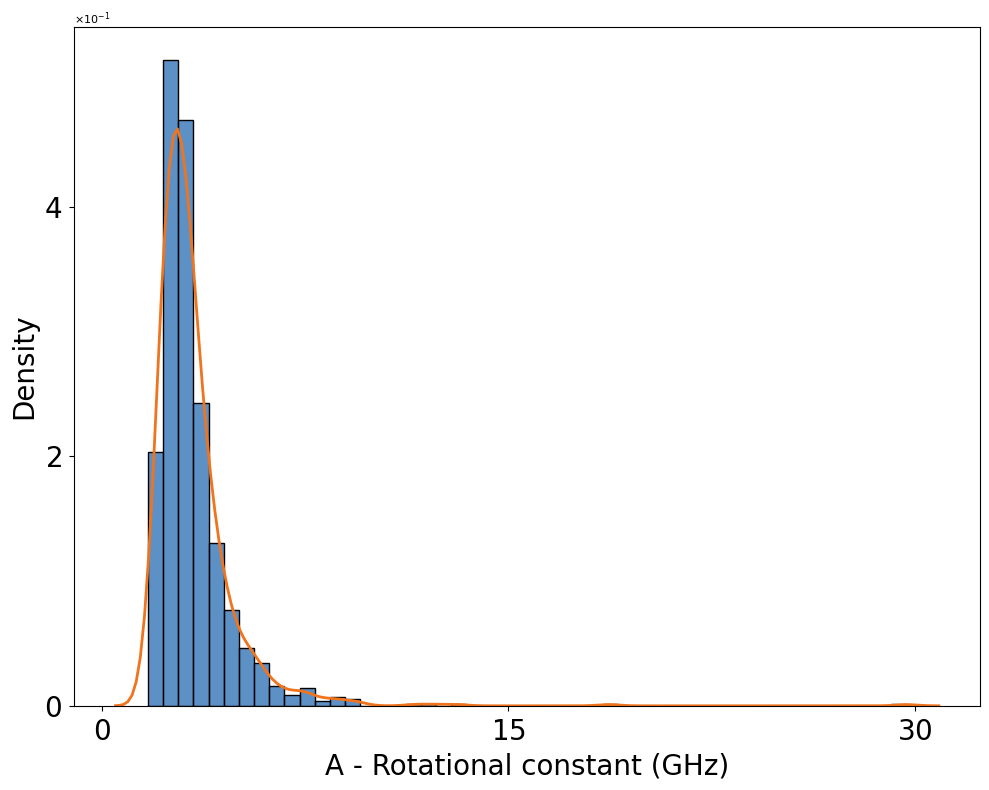

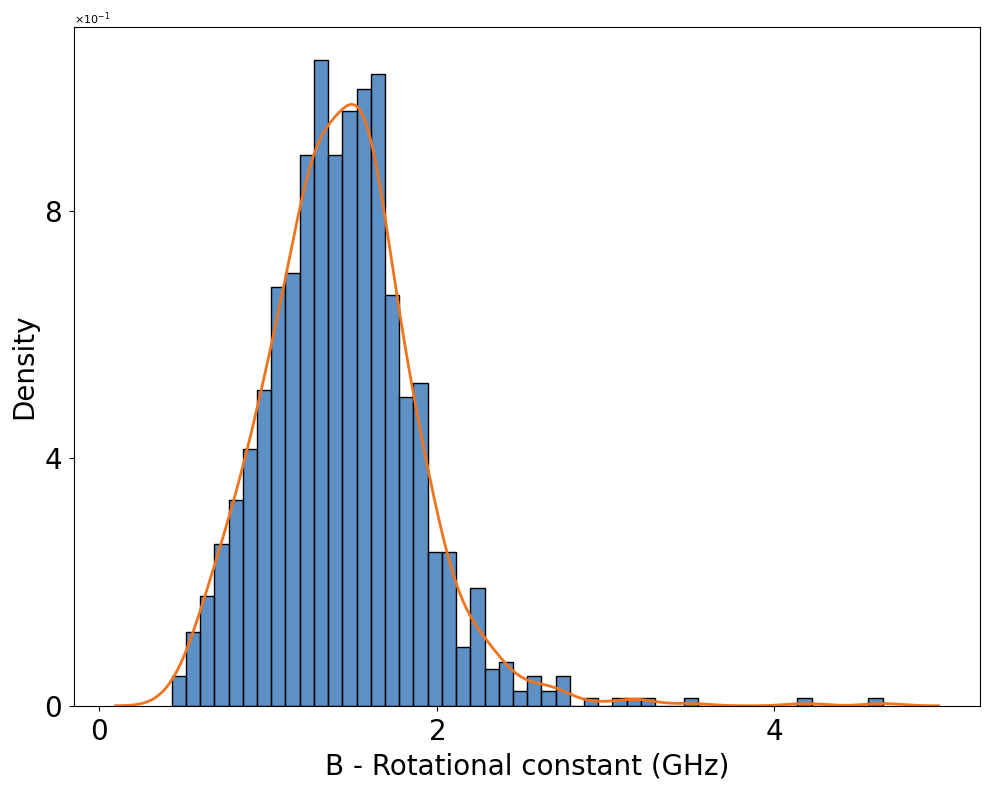

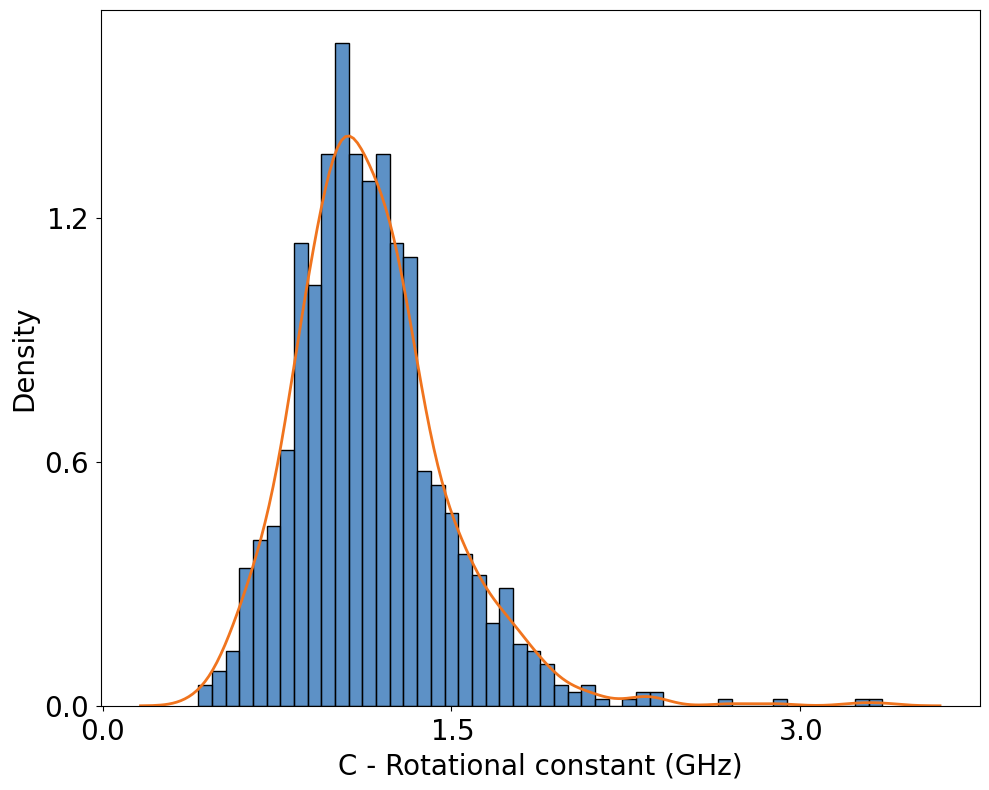

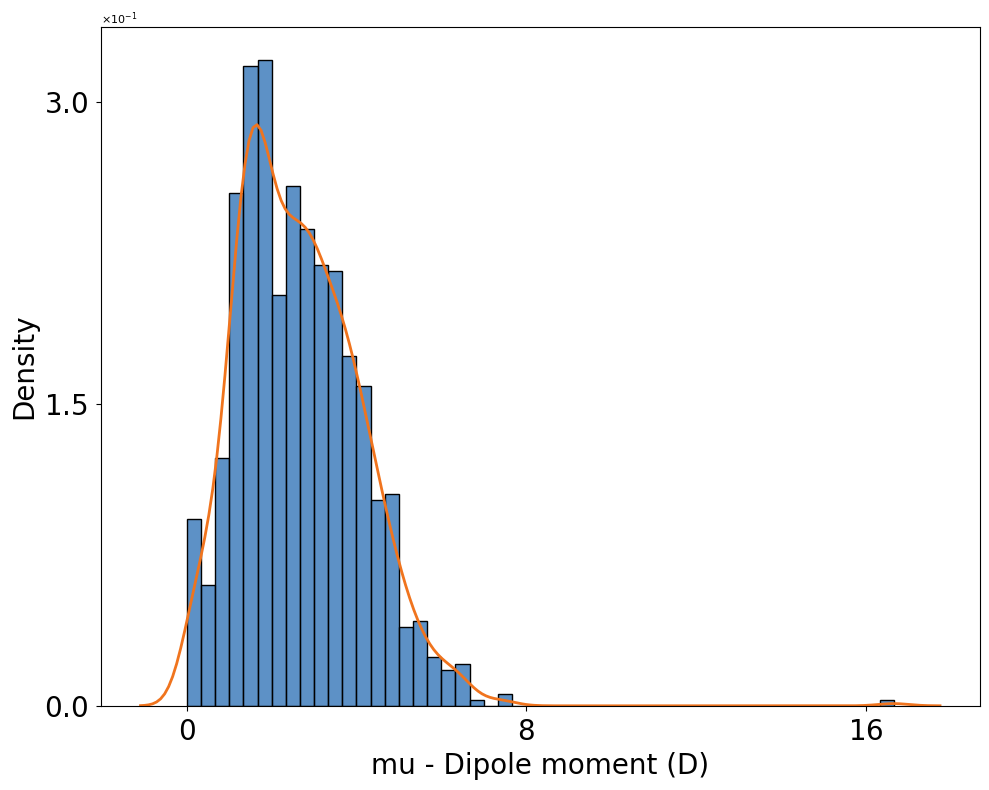

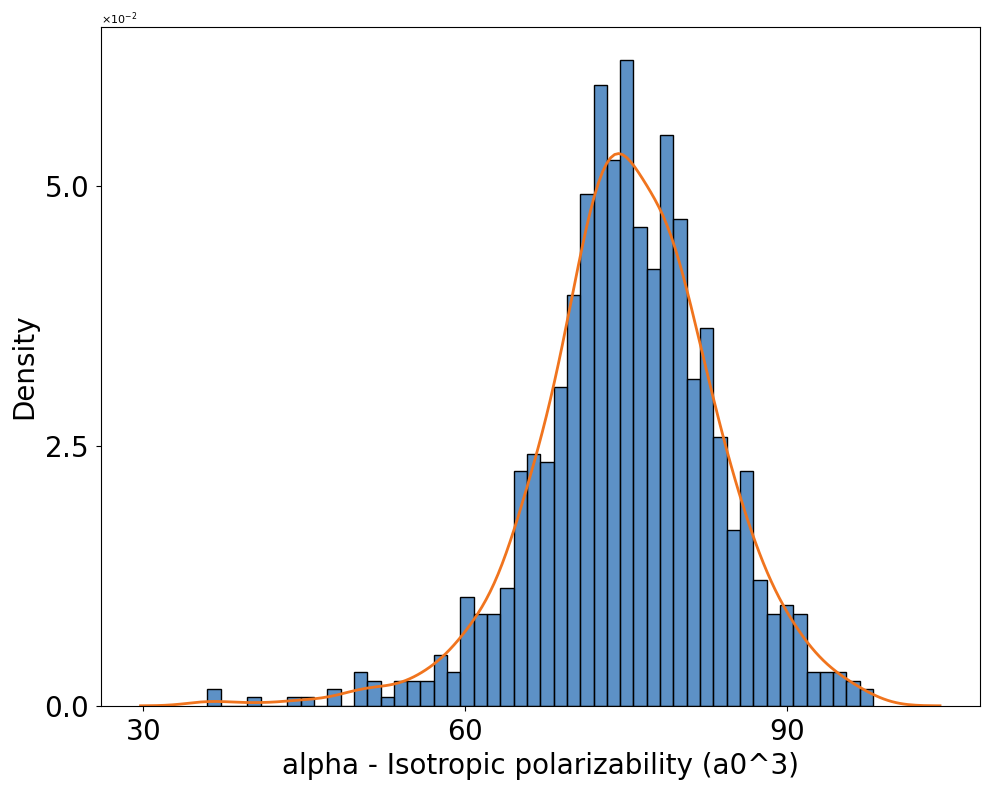

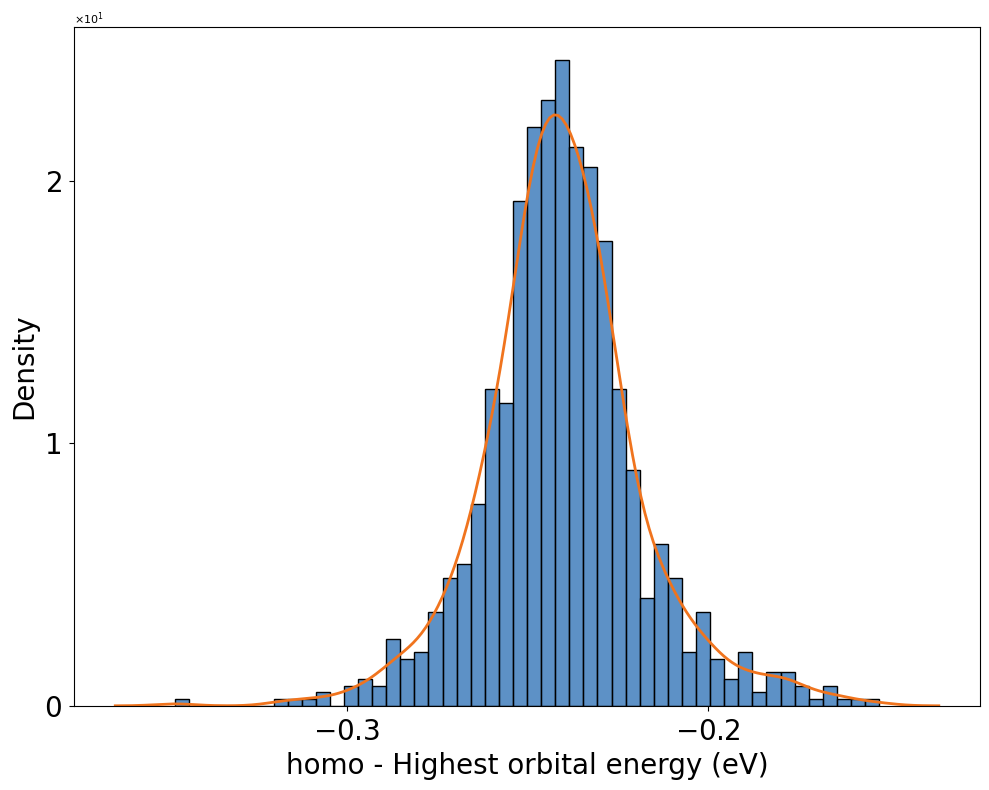

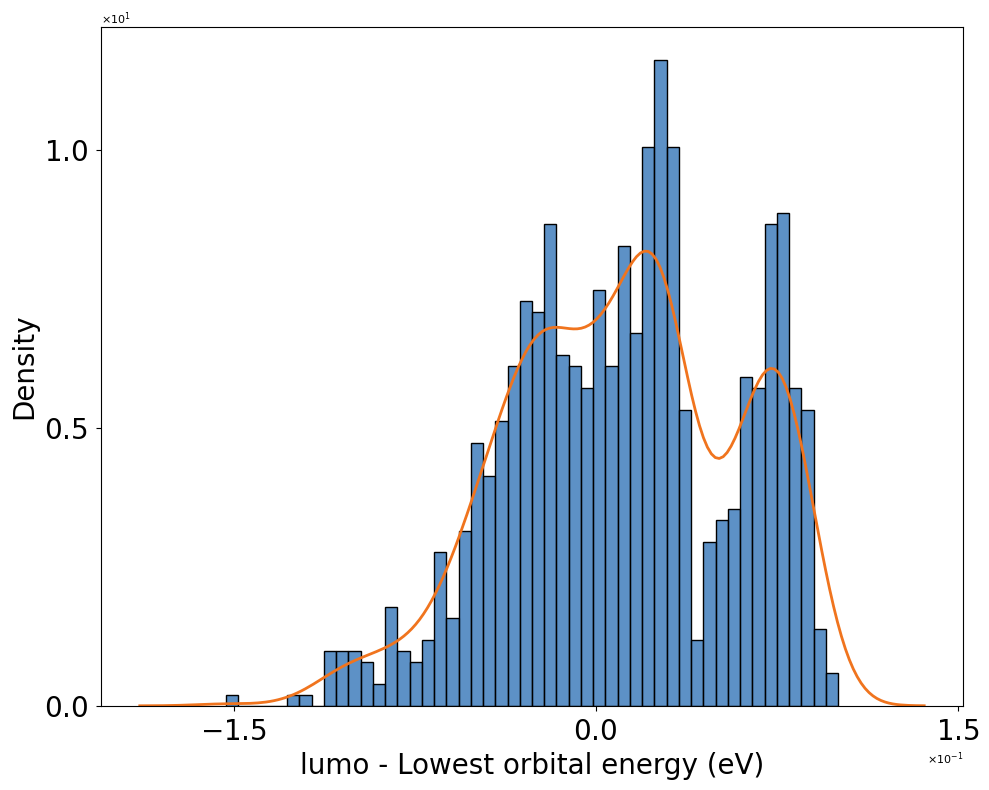

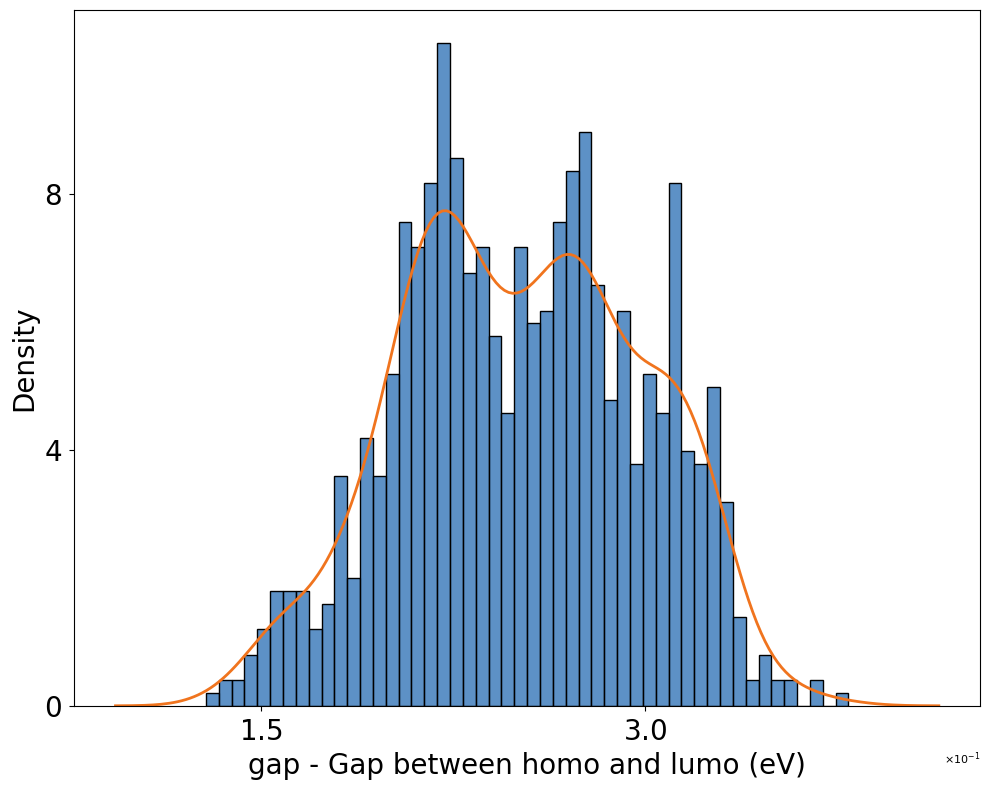

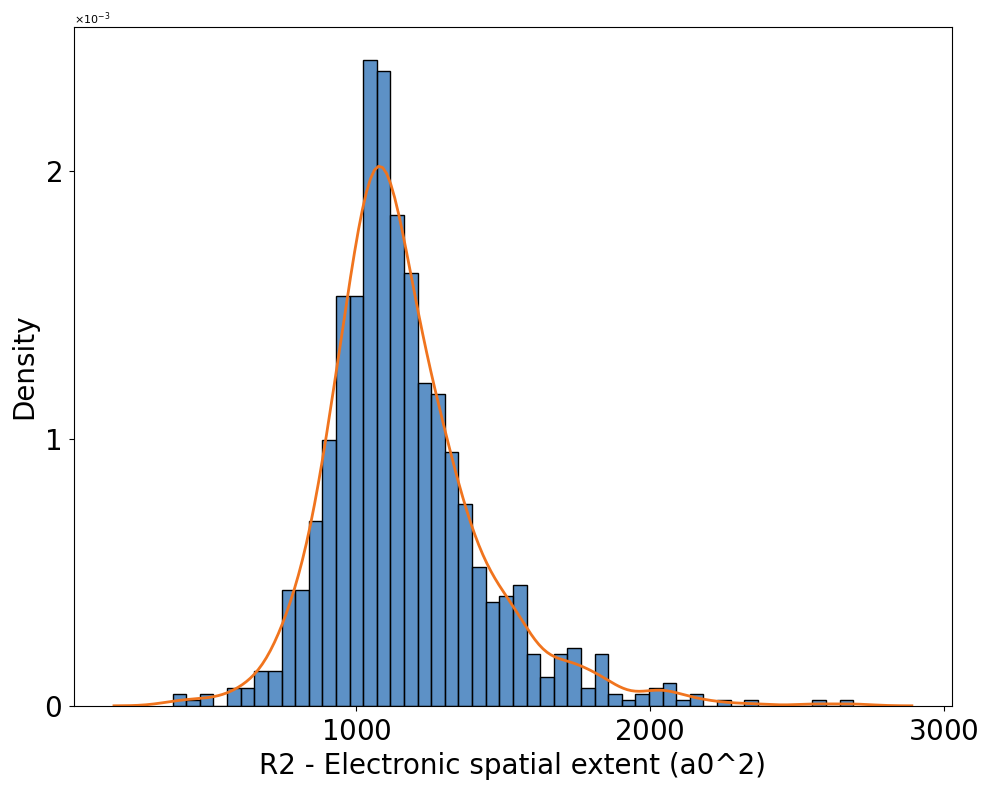

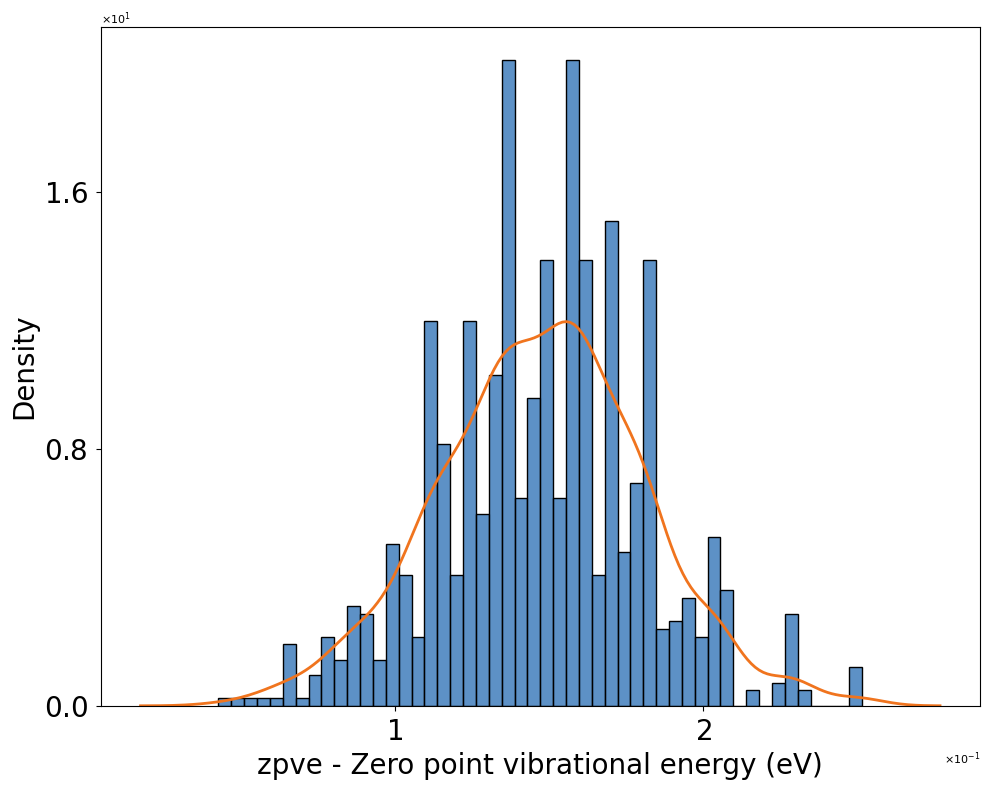

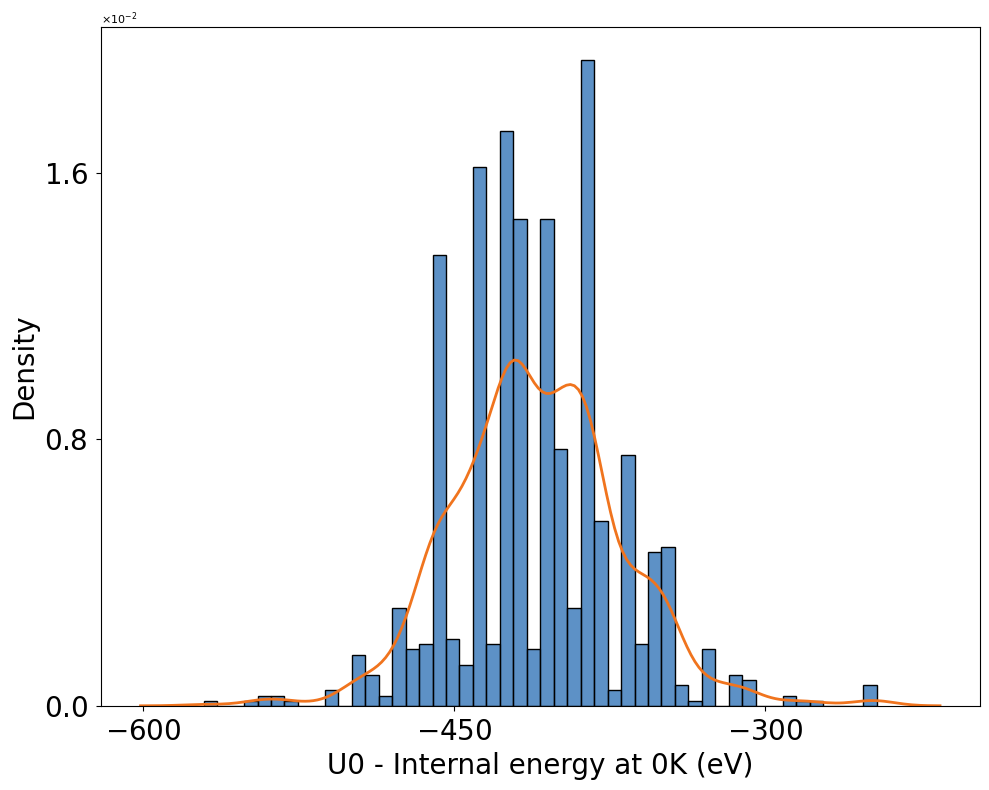

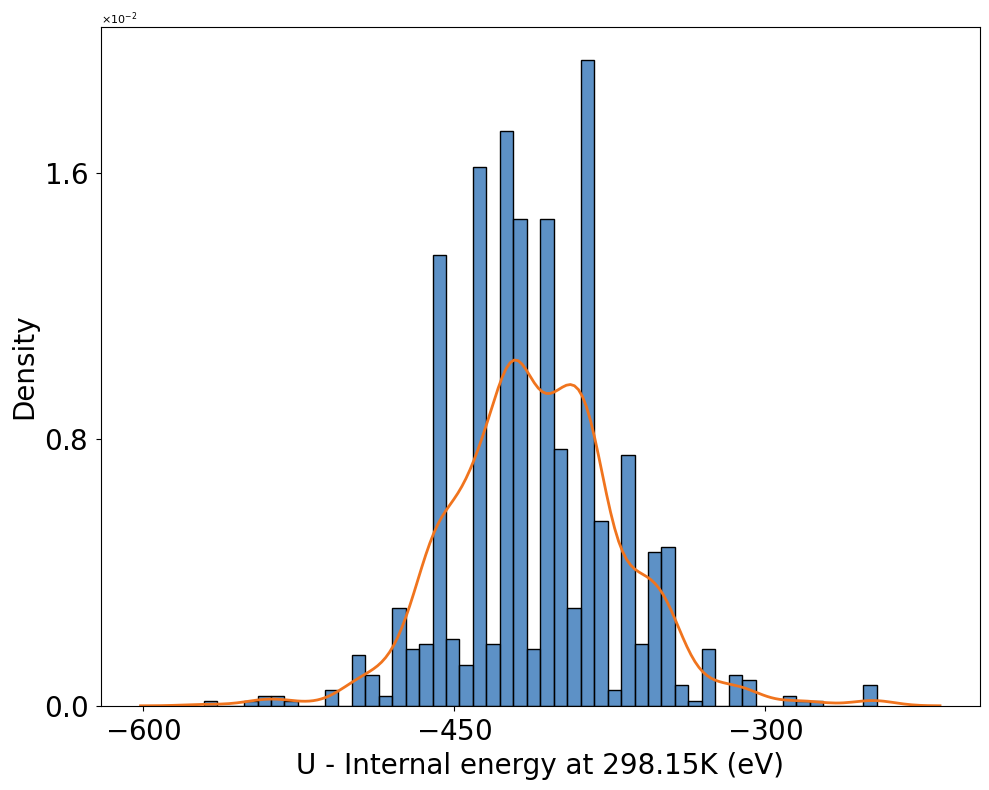

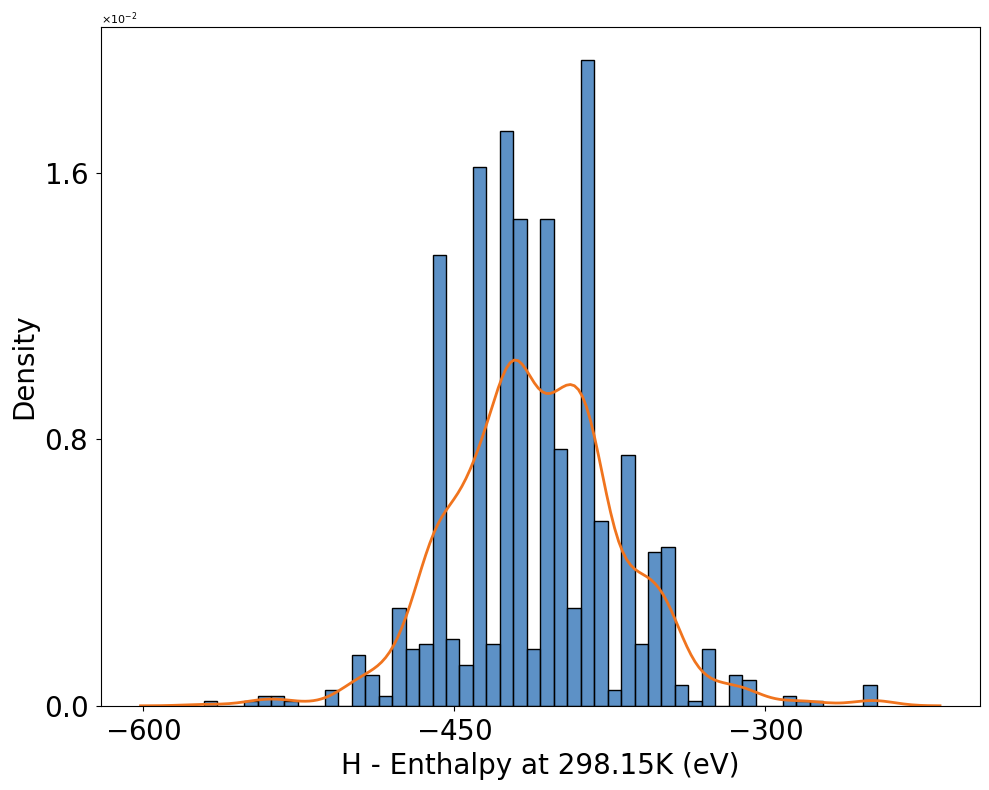

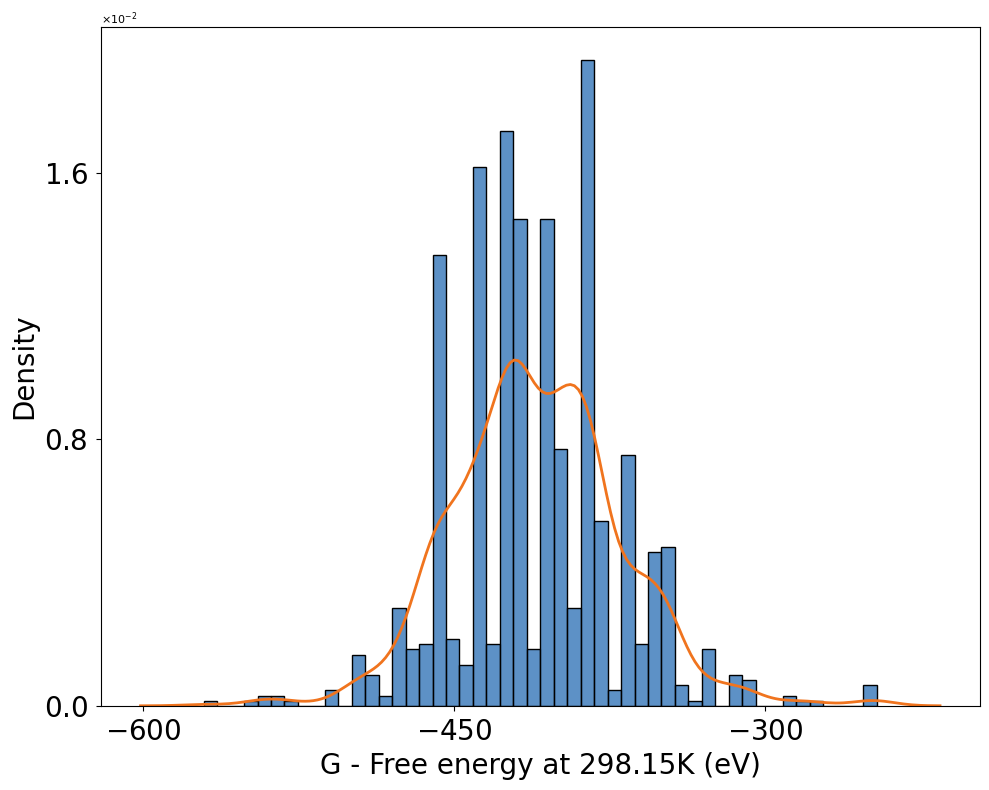

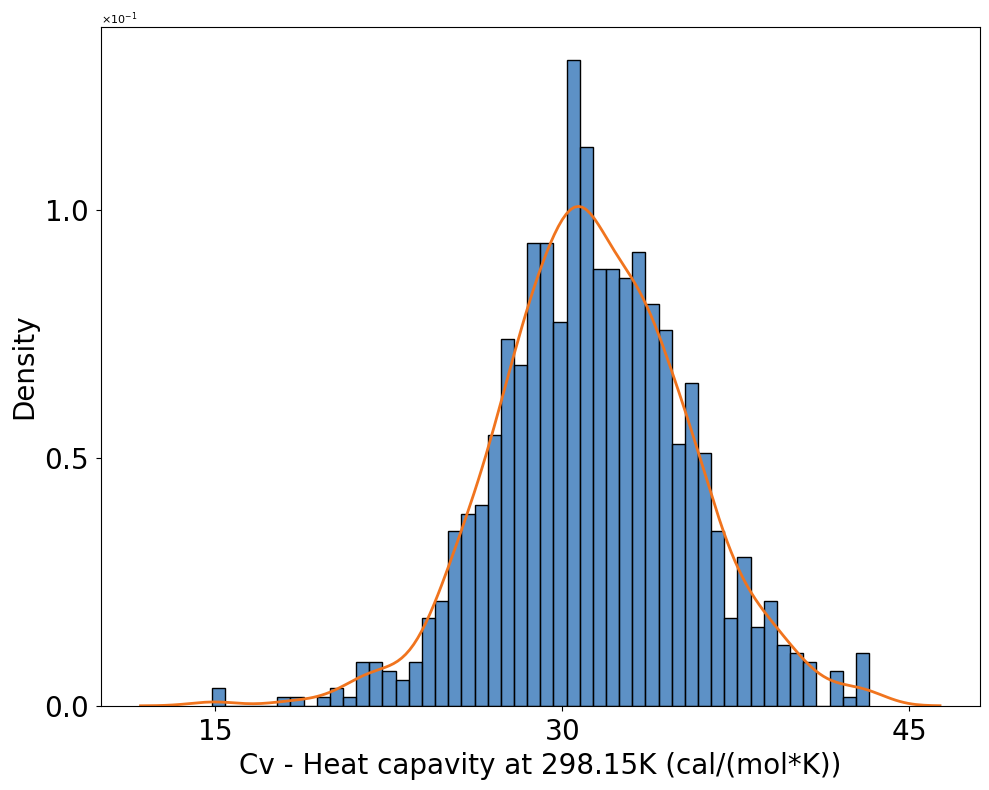

In [5]:
colors = ["#F0741E", "#276CB3"]
plt.style.use("seaborn-v0_8-paper")

target_list = ["A","B",	"C", "mu", "alpha", "homo", "lumo",	"gap", "R2", "zpve", "U0", "U", "H", "G", "Cv"]

target_labels = {
    "A": ("A - Rotational constant (GHz)", "Density"),
    "B": ("B - Rotational constant (GHz)", "Density"),
    "C": (
        "C - Rotational constant (GHz)",
        "Density",
    ),
    "mu": (
        "mu - Dipole moment (D)",
        "Density",
    ),
    "alpha": (
        "alpha - Isotropic polarizability (a0^3)",
        "Density",
    ),
    "homo": (
        "homo - Highest orbital energy (eV)",
        "Density",
    ),
    "lumo": (
        "lumo - Lowest orbital energy (eV)",
        "Density",
    ),
    "gap": (
        "gap - Gap between homo and lumo (eV)",
        "Density",
    ),
    "R2": (
        "R2 - Electronic spatial extent (a0^2)",
        "Density",
    ),
    "zpve": (
        "zpve - Zero point vibrational energy (eV)",
        "Density",
    ),
    "U0": (
        "U0 - Internal energy at 0K (eV)",
        "Density",
    ),
    "U": (
        "U - Internal energy at 298.15K (eV)",
        "Density",
    ),
    "H": (
        "H - Enthalpy at 298.15K (eV)",
        "Density",
    ),
    "G": (
        "G - Free energy at 298.15K (eV)",
        "Density",
    ),
    "Cv": (
        "Cv - Heat capavity at 298.15K (cal/(mol*K))",
        "Density",
    ),
}

for target in target_list:

    fig = plt.figure(figsize=(10, 8))

    ax = fig.add_subplot(1, 1, 1)

    sns.histplot(
        x=df_sorted[f"{target}"],
        fill=True,
        linewidth=1,
        kde=False,
        stat="density",
        color=colors[1],
        ax=ax,
        bins=50,
    )

    sns.kdeplot(x=df_sorted[f"{target}"], linewidth=2, color=colors[0], ax=ax)

    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.set_xlabel(target_labels[target][0], fontsize=20)
    ax.set_ylabel(target_labels[target][1], fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.tight_layout()
    plt.show()


# Calculate and visualize Coulumb matrices

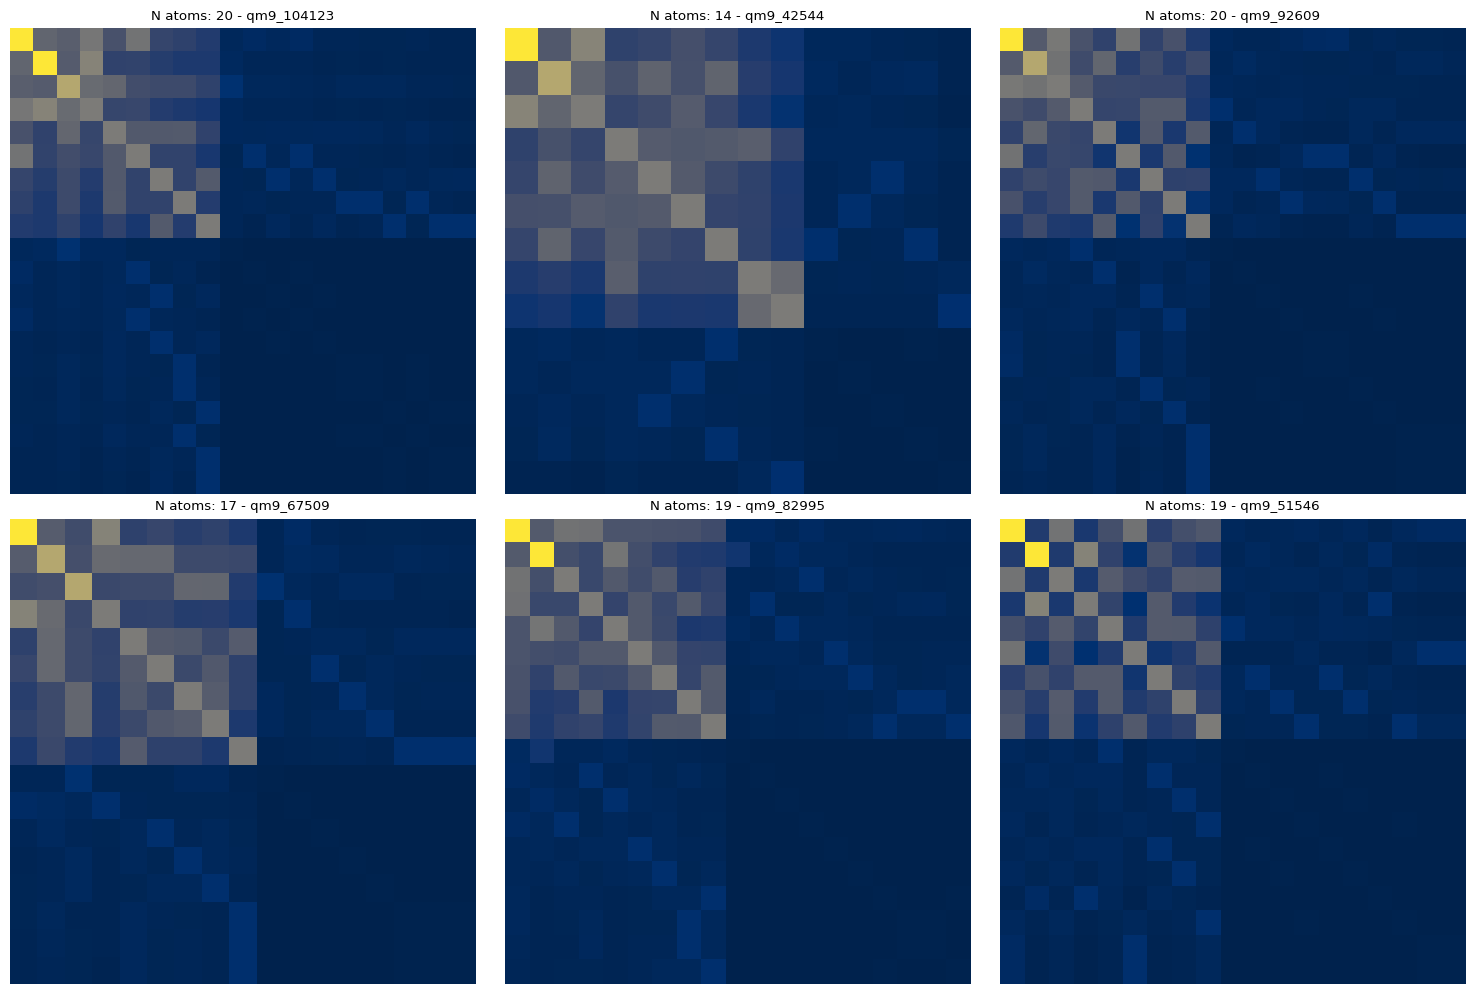

In [6]:
def display_random_images(data_path, n=6, num_cols=3):
    if not isinstance(num_cols, int):
        raise TypeError("ERROR: num_cols must be an integer")
    if not isinstance(n, int):
        raise TypeError("ERROR: n must be an integer")
    if num_cols <= 0:
        raise ValueError("ERROR: num_cols must be greater than zero")
    if n <= 0:
        raise ValueError("ERROR: n must be greater than zero")

    file_list = list(data_path.glob('*.xyz'))
    selected_files = random.sample(file_list, n)

    num_rows = (n + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols,5*num_rows))

    axes = axes.flatten()

    for i, file_path in enumerate(selected_files):
        atomic_numbers, coordinates = read_xyz(file_path)
        c_mat = calculate_coulomb_matrix(atomic_numbers=atomic_numbers, coordinates=coordinates)
        c_mat = sort_by_row_norm(c_mat)
        image = c_mat

        axes[i].imshow(image, cmap="cividis")
        axes[i].set_title(f"N atoms: {len(atomic_numbers)} - {file_path.stem}" )
        axes[i].axis('off')

    for j in range(i + 1, num_rows * num_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

display_random_images(data_path)

# Calculation and padding of eigenvalues

In [7]:
resolution = df_sorted["n_atoms"].max()
print("MAX ATOM NUMBER: ",resolution)
eig_list = []
data = {}
file_list = df_sorted["filename"].to_list()
for file_path in tqdm(file_list):

    atomic_numbers, coordinates = read_xyz(data_path.joinpath(file_path + ".xyz"))
    c_mat = calculate_coulomb_matrix(atomic_numbers=atomic_numbers, coordinates=coordinates)
    c_mat = sort_by_row_norm(c_mat)
    eig = compute_eigenvalues(matrix=c_mat)
    eig = eig.reshape(-1, 1)
    eig = padd_eig(matrix=eig, resolution=resolution)
    eig = normalize_min_max(matrix=eig)
    data[file_path] = eig

MAX ATOM NUMBER:  27


100%|██████████| 1000/1000 [00:00<00:00, 3196.97it/s]


In [8]:
data_list = []
for filename, eig_vector in data.items():
    row = {'filename': filename}
    for i, value in enumerate(eig_vector):
        row[f'eig_{i+1}'] = value[0]
    data_list.append(row)

df_eigenvalue = pd.DataFrame(data_list)

df_eigenvalue.head()

,filename,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,eig_8,eig_9,...,eig_18,eig_19,eig_20,eig_21,eig_22,eig_23,eig_24,eig_25,eig_26,eig_27
0,qm9_125,1.0,0.424723,0.163935,0.111745,0.034471,0.000000,0.000979,0.005605,0.006215,...,0.006098,0.006098,0.006098,0.006098,0.006098,0.006098,0.006098,0.006098,0.006098,0.006098
1,qm9_129,1.0,0.374877,0.211754,0.096639,0.047664,0.000000,0.001940,0.003741,0.005509,...,0.007169,0.007169,0.007169,0.007169,0.007169,0.007169,0.007169,0.007169,0.007169,0.007169
2,qm9_144,1.0,0.405187,0.141450,0.106876,0.029917,0.000000,0.002805,0.005202,0.005511,...,0.005511,0.005511,0.005511,0.005511,0.005511,0.005511,0.005511,0.005511,0.005511,0.005511
3,qm9_189,1.0,0.298386,0.256721,0.127777,0.036587,0.022328,0.000000,0.002852,0.004101,...,0.004101,0.004101,0.004101,0.004101,0.004101,0.004101,0.004101,0.004101,0.004101,0.004101
4,qm9_347,1.0,0.379229,0.262814,0.134999,0.068533,0.021219,0.000000,0.002656,0.003957,...,0.006714,0.006714,0.006714,0.006714,0.006714,0.006714,0.006714,0.006714,0.006714,0.006714


In [9]:
target = "Cv" # can be one of ["A","B","C","mu","alpha","homo","lumo","gap","R2","zpve","U0","U","H","G","Cv"]

df_merged = pd.merge(df_eigenvalue, df_sorted[['filename', target]], on='filename', how='left')

df_merged.head(10)

,filename,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,eig_8,eig_9,...,eig_19,eig_20,eig_21,eig_22,eig_23,eig_24,eig_25,eig_26,eig_27,Cv
0,qm9_125,1.0,0.424723,0.163935,0.111745,0.034471,0.000000,0.000979,0.005605,0.006215,...,0.006098,0.006098,0.006098,0.006098,0.006098,0.006098,0.006098,0.006098,0.006098,18.140
1,qm9_129,1.0,0.374877,0.211754,0.096639,0.047664,0.000000,0.001940,0.003741,0.005509,...,0.007169,0.007169,0.007169,0.007169,0.007169,0.007169,0.007169,0.007169,0.007169,19.864
2,qm9_144,1.0,0.405187,0.141450,0.106876,0.029917,0.000000,0.002805,0.005202,0.005511,...,0.005511,0.005511,0.005511,0.005511,0.005511,0.005511,0.005511,0.005511,0.005511,14.866
3,qm9_189,1.0,0.298386,0.256721,0.127777,0.036587,0.022328,0.000000,0.002852,0.004101,...,0.004101,0.004101,0.004101,0.004101,0.004101,0.004101,0.004101,0.004101,0.004101,15.099
4,qm9_347,1.0,0.379229,0.262814,0.134999,0.068533,0.021219,0.000000,0.002656,0.003957,...,0.006714,0.006714,0.006714,0.006714,0.006714,0.006714,0.006714,0.006714,0.006714,22.345
5,qm9_610,1.0,0.427356,0.205141,0.120894,0.077288,0.046448,0.000000,0.001777,0.002863,...,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,22.227
6,qm9_630,1.0,0.343524,0.248150,0.101639,0.094657,0.033362,0.000000,0.000653,0.001869,...,0.006087,0.006087,0.006087,0.006087,0.006087,0.006087,0.006087,0.006087,0.006087,22.773
7,qm9_671,1.0,0.289865,0.200316,0.121277,0.062962,0.048206,0.000000,0.005901,0.005543,...,0.006104,0.006104,0.006104,0.006104,0.006104,0.006104,0.006104,0.006104,0.006104,18.523
8,qm9_813,1.0,0.414566,0.251819,0.162282,0.098296,0.072653,0.027071,0.000000,0.005292,...,0.005223,0.005223,0.005223,0.005223,0.005223,0.005223,0.005223,0.005223,0.005223,26.249
9,qm9_862,1.0,0.226566,0.268112,0.168942,0.100815,0.035809,0.032498,0.000368,0.000000,...,0.005765,0.005765,0.005765,0.005765,0.005765,0.005765,0.005765,0.005765,0.005765,25.372


# Ridge regression

In [11]:
X = df_merged.drop(['filename', target], axis=1)
y = df_merged[target]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge_model = Ridge(alpha=1.0)

ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Ridge - MSE: {mse}')
print(f'Ridge - R2: {r2}')

Ridge - MSE: 8.757243907413715
Ridge - R2: 0.34228978800935095


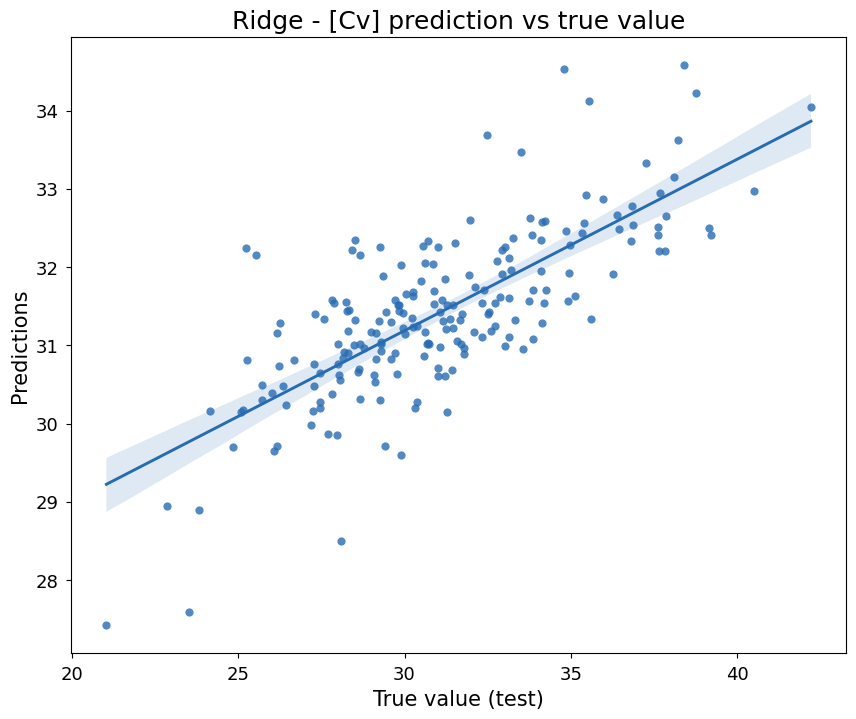

In [21]:
plt.figure(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, color=colors[1], scatter_kws={'s': 35})
plt.xlabel("True value (test)", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.title(f"Ridge - [{target}] prediction vs true value", fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

# XGBoost

In [22]:
model = xgb.XGBRegressor()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
params = {
    "n_estimators": 100,  # The number of boosting rounds
    "learning_rate": 0.1,  # Step size shrinkage
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "colsample_bytree": 1.0,  # Subsample ratio of columns when constructing each tree
    "subsample": 1.0,  # Subsample ratio of the training instances
    "reg_alpha": 0,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "booster": "gbtree",  # The type of model to use, can be 'gbtree', 'gblinear', or 'dart'
    "objective": "reg:squarederror",  # The learning task and corresponding learning objective
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node of the tree
    "random_state": 0,  # Random number seed
    "verbosity": 2,  # The degree of verbosity (0 = silent, 1 = warning, 2 = info, 3 = debug)
}

model = xgb.XGBRegressor(**params)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost - MSE: {mse}")
print(f"XGBoost - R2: {r2}")


XGBoost - MSE: 1.8974596719593888
XGBoost - R2: 0.8574918528840333


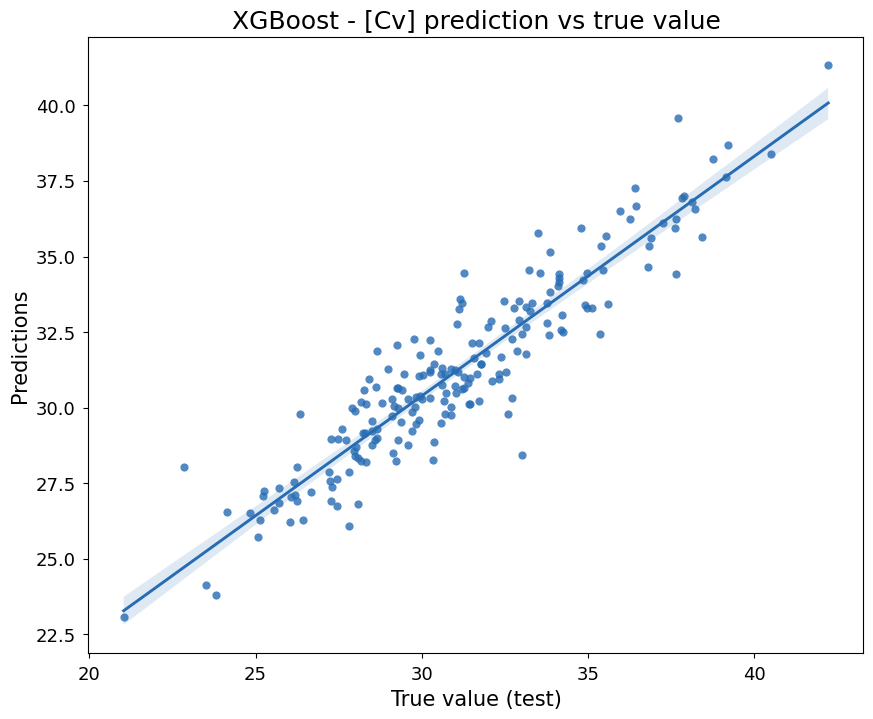

In [23]:
plt.figure(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, color=colors[1], scatter_kws={'s': 35})
plt.xlabel("True value (test)", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.title(f"XGBoost - [{target}] prediction vs true value", fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

# XGBoost feature importance

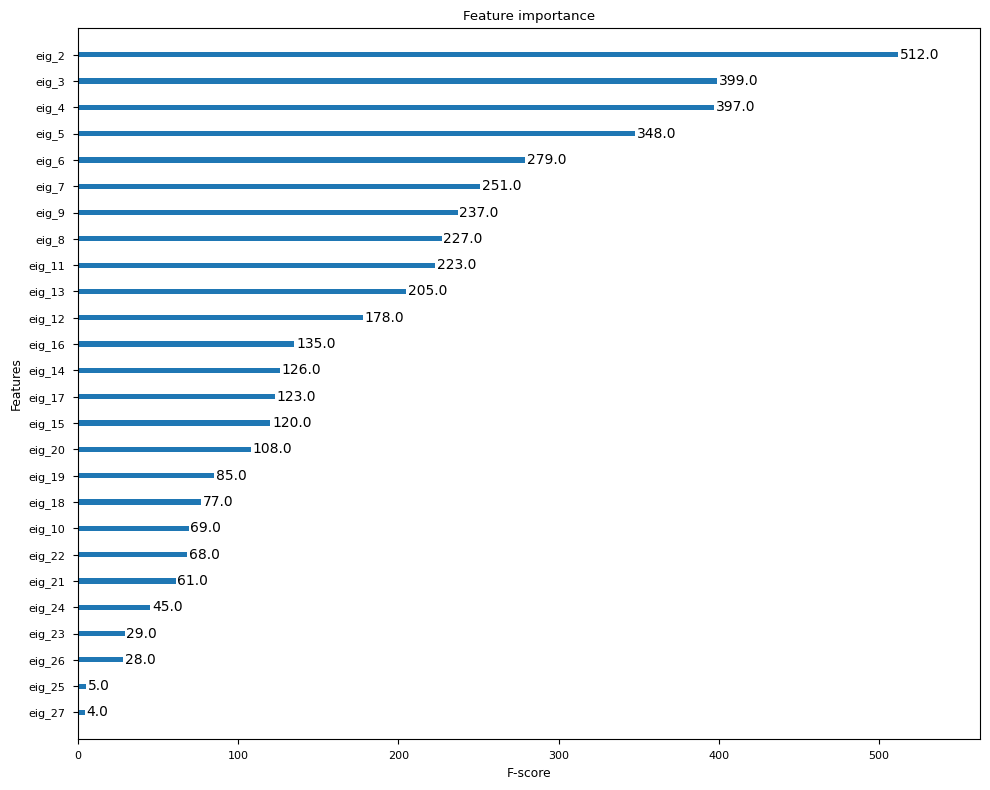

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(model,
                max_num_features=resolution,
                importance_type='weight',
                title='Feature importance',
                xlabel='F-score',
                ylabel='Features',
                grid=False,
                show_values=True,
                ax=ax)

plt.tight_layout()
plt.show()